# Desafio Prático de PDI - ICTS

HDCP é a sigla para “High-bandwidth Digital Content Protection” e trata-se de um protocolo implementado nos dispositivos HDMI e DVI para impedir a transmissão de dados sem a devida autorização dos proprietários legais.

- Resumindo, é um sistema antipirataria para conteúdos digitais. 


- O gerador de sinal HDMI produz uma imagem em color bar e um OSD (On-screen display) que contém os status do HDCP e do EDID (Extended Display Identification Data) podendo ser OK e/ou NG (No Good) como mostrado na imagem abaixo:

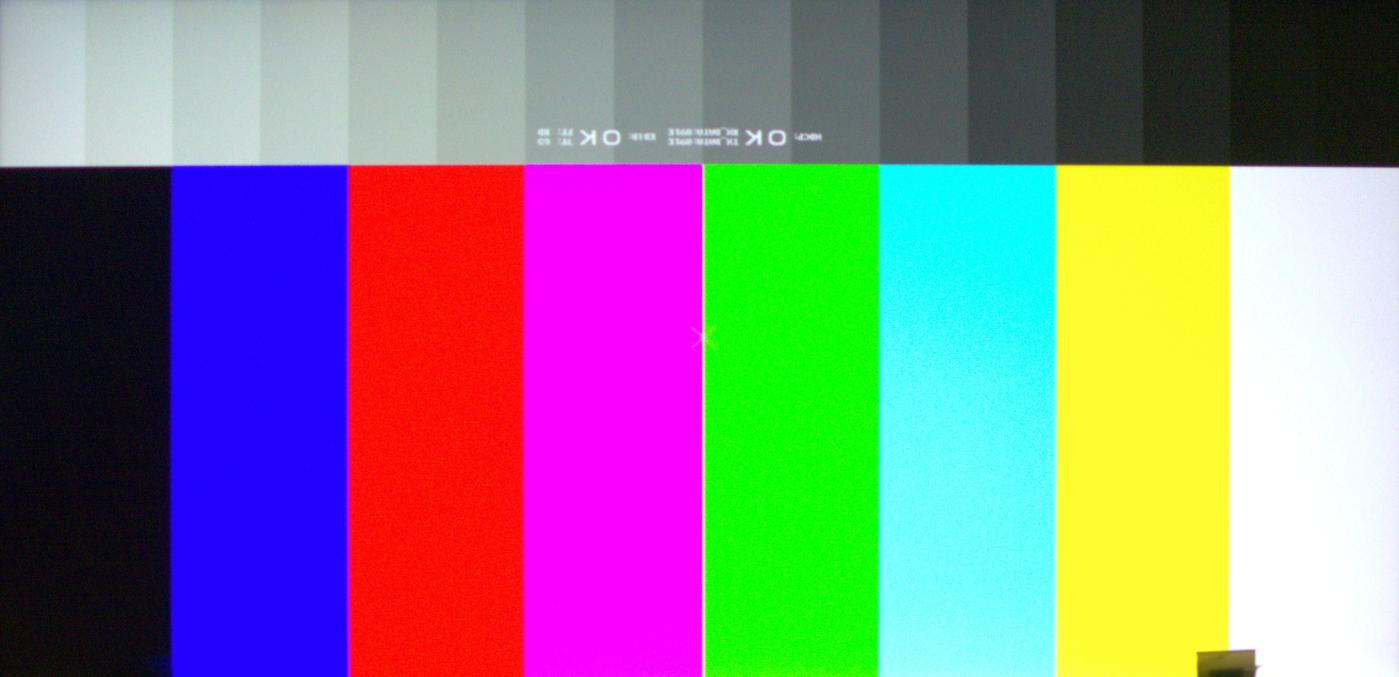

### 1. Escreva um algoritmo em Python que identifique os textos presente em uma imagem fornecida como entrada e gere como saída uma tupla que informe se a palavra OK se encontra ou não na imagem.

- Observe atentamente que as imagens estão com os textos de cabeça para baixo, pois a aquisição da imagem se faz com o display virado de cabeça para baixo, e que a solução precisa identificar os textos e exibi-los na saída.


- Há a possibilidade de ter imagens que não apresentem nenhum texto devido a falha de comunicação com o gerador de sinal, nesse caso a saída deve informar que a palavra OK não foi encontrada.


- Atente-se a um código limpo, organizado, documentado e com ideias claras da solução proposta.

# Solução:

- A solução implementada fez uso de técnicas de Visão Computacional e Inteligência Artificial para determinar o status das imagens.


    - Transformações foram aplicadas à imagem para eliminar informações irrelevantes e localizar os textos na mesma;
    - Determinada a ROI, foi possível utilizar a ferramenta Tesseract de reconhecimento de caracteres para determinar o que estava escrito e localizar os OKs;
    - Determinada a posição dos OKs a determinação dos status HDCP e EDID se torna trivial;

In [1]:
from IPython.display import clear_output

import os, copy, glob, cv2
import numpy as np
import pytesseract as ocr
import matplotlib.pyplot as plt

In [2]:
def carrega_imagem(src_path, im_size = '', color_flag = '', flip = ''):
    # Carrega uma imagem a partir do seu endereço
    # Redimensiona, muda seu espaço de cores ou flipa a imagem caso especificado
    img = cv2.imread(src_path)
    img = cv2.resize(img, im_size) if im_size != '' else img
    img = cv2.flip(img, flip) if flip != '' else img
    img = cv2.cvtColor(img, color_flag) if color_flag != '' else img
    return img

def hsv_filter(src_img, lower, upper):
    # Realiza a filtragem de uma imagem no espaço HSV
    # A imagem é retornada no espaço RGB
    hsv_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower, upper)
    hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
    return cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

In [3]:
def determina_roi(src_img, params):
    ''' Recebe a imagem de entrada e determina a região de interesse (ROI):
    
    Argumentos:
            src_img - imagem de entrada;
            params  - dicionário com parâmetros;
    Retornos:
            buffer  - imagem em escala de cinza pré-processada para o reconhecimento de caracteres;
            mask    - imagem b&w onde pixels brancos indicam a provável localização de textos na imagem;
    '''
    
    # Pré processamento para o reconhecimento de caracteres.
    # Filtragem da imagem de entrada no espaço hsv para descartar informações irrelevantes.
    # A imagem também é convertida para escala de cinza e tem seu histograma equalizado para ajustar o contraste.
    buffer = hsv_filter(src_img, lower = params['hsv_lower'], upper = params['hsv_upper'])
    buffer = cv2.cvtColor(buffer, cv2.COLOR_RGB2GRAY)
    buffer = cv2.equalizeHist(buffer)
    
    # Determinação da provável localização de textos na imagem.
    # Aplicação de um detector de bordas para eliminar o fundo da imagem. A imagem é, em seguida, limiarizada.
    mask = cv2.Canny(buffer, params['canny_lower'], params['canny_upper'])
    _, mask = cv2.threshold(mask, params['threshold_lower'], params['threshold_upper'], cv2.THRESH_BINARY)
    
    # Dilatação preventiva da imagem para evitar o descarte de partes do texto.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, params['dilatation_size'])
    mask = cv2.dilate(mask, kernel, iterations = parameters['n_dilatations'])
    
    # Aplicação da máscara sobre a imagem pré-processada para redução de ruído.
    buffer = cv2.bitwise_and(buffer, buffer, mask=mask)
    
    return buffer, mask

def verifica_rects(buffer, mask, params):
    ''' Recebe as imagens pré-processadas e verifica quais partes da ROI contém a palvra 'OK':
    
    Argumentos:
            buffer  - imagem em escala de cinza pré-processada para o reconhecimento de caracteres;
            mask    - imagem b&w onde pixels brancos indicam a provável localização de textos na imagem;
            params  - dicionário com parâmetros;
    Retornos:
            rects   - lista de rects que contém a palavra 'OK';
    '''
    contornos, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    rects = []
    for c, contorno in enumerate(contornos):
        [x, y, w, h] = cv2.boundingRect(contorno)

        # Desconsidera rects muito pequenas ou muito grandes para acelerar o processamento
        if w < params['min_rect_dim'] and h < params['min_rect_dim']:
            continue
            
        if w > params['max_rect_dim'] or h > params['max_rect_dim']:
            continue

        # Cropa uma região da imagem onde possivelmente há texto e a binariza para melhorar os resultados do OCR
        crop = buffer[y :y +  h , x : x + w]
        _, crop = cv2.threshold(crop,125,255,cv2.THRESH_BINARY_INV)

        # Utiliza o Tesseract para realizar o reconhecimento dos caracteres (OCR) na região cortada.
        # A configuração utilizada pressupõe a presença de uma única frase por rect.
        string = ocr.image_to_string(crop, config='--psm 7')

        # Verifica a quantidade de 'OKs' na string produzida pelo OCR
        # 0 'OKs' indica um falso positivo na detecção de texto no recorte atual e a rect é ignorada.
        # 1 'OK'  indica a detecção correta de uma das regiões desejadas.
        # 2 'OKs' indica uma falha na determinação da ROI, os 2 OKs foram agrupados em uma única rect, uma correção é aplicada.
        if len(string.lower().split('ok')) == 2:
            rects.append( (x, y, w, h) )
        elif len(string.lower().split('ok')) == 3:
            rects.append( (x, y, w//2, h) )
            rects.append( (x+w//2, y, w//2, h) )
    
    return rects

def determina_status(src_img, rect, h_scale=3, sensitividade = 15):
    ''' Recebe a imagem de entrada e a rect referente a um dos OKs e determina se é referente ao status do HDCP ou do EDID:
    - Para isso se expande a rect na vertical e contabiliza-se a quantidade de pixels verdes e magentas.
    O OK é referente ao status do EDID caso hajam mais pixels magenta e referente ao status do HDCP caso contrário.
    
    Argumentos:
            src_img       - imagem a ser verificada;
            rect          - região na qual um OK foi identificado;
            h_scale       - determina 
            sensitividade - 
    Retornos:
            Um string indicando 'EDID' ou 'HDCP';
    '''
    img = copy.deepcopy(src_img)
    
    # Expande o recorte na vertical
    x, y, w, h = rect
    crop = img[y - h_scale*h :y + h_scale*h , x - w//2 : x + w//2]

    # Conta pixels verdes
    green_mask = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV)
    green_mask = cv2.inRange(green_mask, np.array([60 - sensitividade, 100, 100]), np.array([60 + sensitividade, 255, 255]))
    green_pxls = np.sum(green_mask)

    # Conta pixels magentas
    magenta_mask = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV)
    magenta_mask = cv2.inRange(magenta_mask, np.array([150 - sensitividade, 100, 100]), np.array([150 + sensitividade, 255, 255]))
    magenta_pxls = np.sum(magenta_mask)
    
    # Determina a saída
    if magenta_pxls > green_pxls:
        return 'EDID'
    return 'HDCP'

def status_check(src_path, params):
    ''' Recebe o endereço de uma imagem e um dicionário de parâmetros e determina os status do HDCP e EDID:
    
    Argumentos:
            src_path - caminho da imagem a ser verificada;
            params   - dicionário com parâmetros;
    Retornos:
            dst_img  - Imagem com marcação das rects com a palavra 'OK';
            status   - Tupla indicando os status do HDCP e EDID;
    '''
    EDID_status = 'NG'
    HDCP_status = 'NG'
    
    # Carregamento da imagem a ser verificada, a imagem é carregada no espaço RGB e flipada nos eixos vertical e horizontal.
    src_img = carrega_imagem(src_path, im_size = params['size_of_img'], color_flag = cv2.COLOR_BGR2RGB, flip = -1)
    
    # Determinação da região de interesse
    buffer, mask = determina_roi(src_img, params)
    
    # Verifica a imagem pela presença da palavra 'OK'
    rects = verifica_rects(buffer, mask, params)
    
    # Cópia da imagem para a marcação das rects
    dst_img = copy.deepcopy(src_img)
    
    # Desenha as rects em verde
    for rect in rects:
        x, y, w, h = rect
        cv2.rectangle(dst_img, (x, y), (x + w, y + h), (0, 255, 0), 5)
        
        # Verifica se o OK detectado é referente ao status do EDID ou do HDCP
        if determina_status(src_img, rect) == 'EDID':
            EDID_status = 'OK'
        else:
            HDCP_status = 'OK'
    
    # Produz a tupla conforme solicitado
    status = (HDCP_status, EDID_status)
    
    return dst_img, status

# Verificação:

In [4]:
# Dicionário de parâmetros utilizados
parameters = { 'size_of_img': (2400, 1200),
               'hsv_lower': np.array([0, 10, 210]),
               'hsv_upper': np.array([255, 255, 255]),
               'canny_lower': 100,
               'canny_upper': 150,
               'threshold_lower': 165,
               'threshold_upper': 185,
               'dilatation_size': (5,3),
               'n_dilatations': 5,
               'min_rect_dim': 50,
               'max_rect_dim': 400}

# Produz uma lista com os caminhos das imagens de teste
img_path_list = glob.glob('..\\imagens\\*.*')

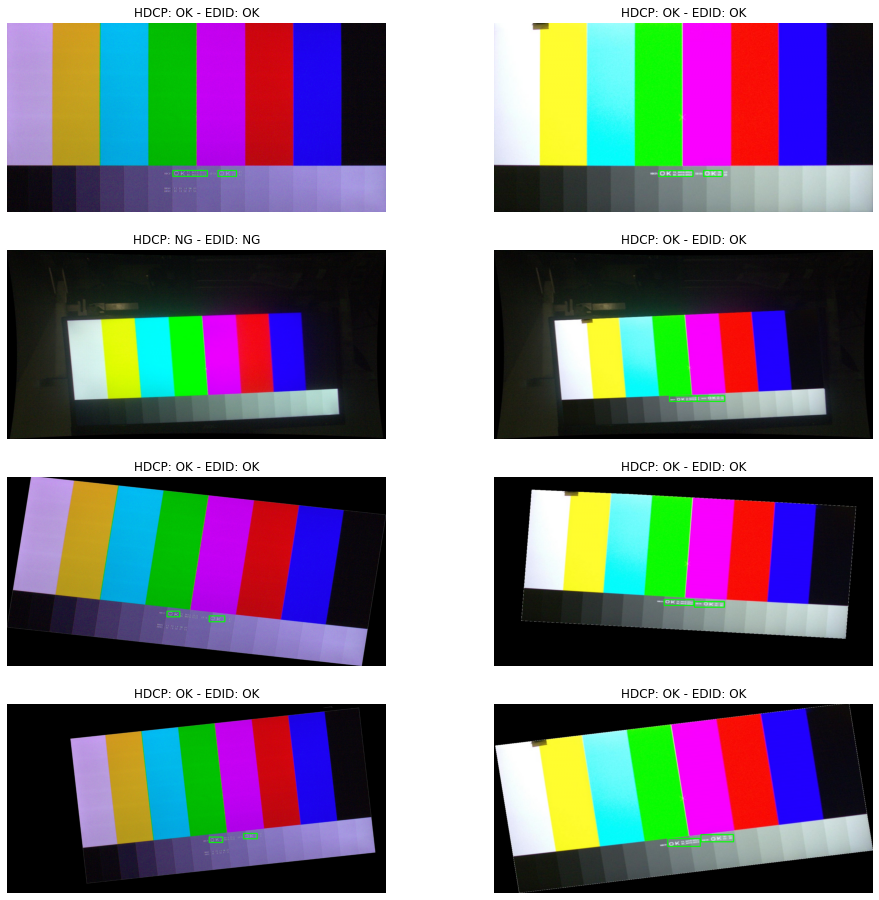

In [5]:
# Plota as imagens e os respectivos status conforme solicitado.

n_imgs = len(img_path_list)
fig = plt.figure(figsize=(16, 16))

for i, path in enumerate(img_path_list):
    
    if (i+1)%2 == 0:
        clear_output(wait=True)
        print('{}/{}'.format(i+1, n_imgs), end='\r')
    
    rct_img, status = status_check(path, parameters)
    ax = fig.add_subplot(4, 2, i+1)
    ax.imshow(rct_img/255)
    ax.axis('off')
    ax.set_title('HDCP: {} - EDID: {}'.format(status[0], status[1]))

# Teste Utilizando Data Augmentation

In [6]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


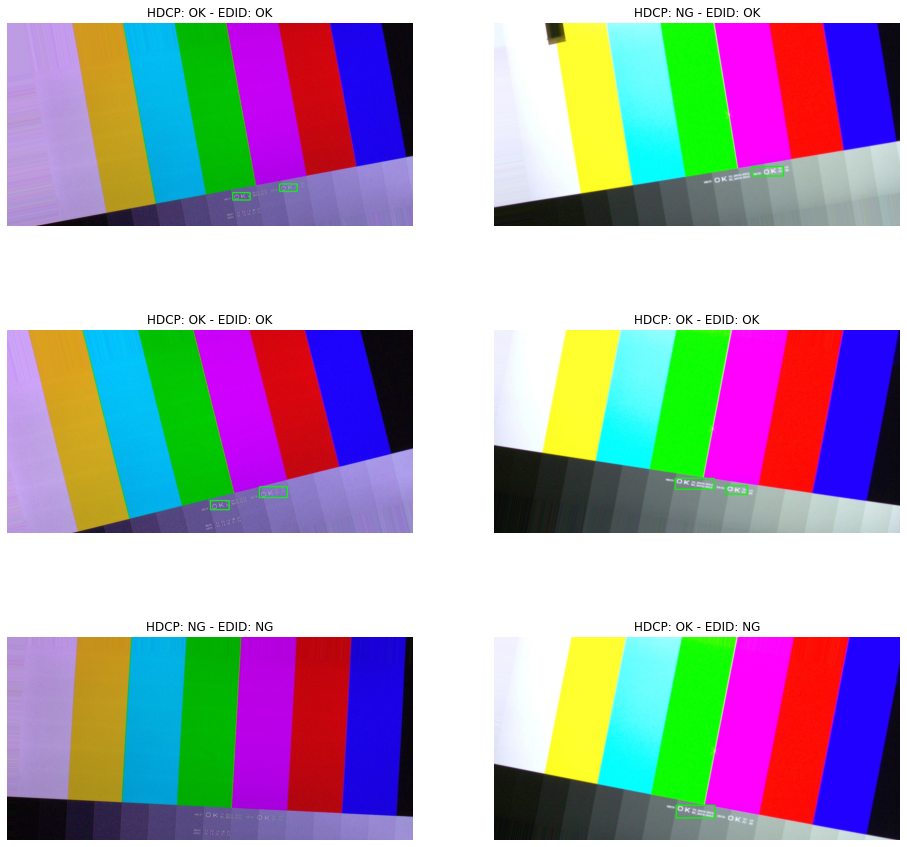

In [7]:
# Utilização do gerador de Data Augmentation do Keras para produzir novas imagens de teste
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.05,
                             zoom_range=0.1,
                             brightness_range=(0.95, 1.05))

# Carregando os exemplos fornecidos
original_data = np.zeros( (2, 1200, 2400, 3) )
original_data[0] = carrega_imagem(img_path_list[0], im_size = parameters['size_of_img'], color_flag = cv2.COLOR_BGR2RGB)
original_data[1] = carrega_imagem(img_path_list[1], im_size = parameters['size_of_img'], color_flag = cv2.COLOR_BGR2RGB)

# 6 novas imagens são produzidas e o status é verificado
n_lines = 3
fig = plt.figure(figsize=(16, 16))
for line, batch in enumerate(datagen.flow(original_data, batch_size = 2)):
    clear_output(wait=True)
    print('{}/{}'.format(line+1, n_lines), end='\r')
        
    for col, aug_image in enumerate(batch):
        ax = fig.add_subplot(n_lines, 2, 2*line+col+1)
        cv2.imwrite('..\\temp.jpg', cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
        rct_img, status = status_check('..\\temp.jpg', parameters)
        plt.imshow(rct_img/255)
        ax.axis('off')
        ax.set_title('HDCP: {} - EDID: {}'.format(status[0], status[1]))
    
    if (line+1) % n_lines == 0:
        break

# Observações:

- A detecção não é infalível, de modo que imagens com baixa qualidade levam a falhas na detecção do OK pela máscara criada ou na detecção do texto pelo OCR.
    - Nessas situações o rótulo NG (Not Good) é atribuído ao status correspondente;